### TELCO CUSTOMER CHURN
#### SECTION 4 - FEATURE SELECTION AND MODEL DEPLOYMENT

***The goal of this section is to selecting the best features for the previous selected model, and finally deploy the model to Dashboard.*** 

### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import pylab

from scipy.stats import anderson
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE

import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_ready.csv')

In [3]:
df.head()

,Tenure,MonthlyCharges,TotalCharges,Churn,Gender_Female,Gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.013889,0.115423,0.003437,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0.472222,0.385075,0.217564,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0.027778,0.354229,0.012453,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0.625000,0.239303,0.211951,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0.027778,0.521891,0.017462,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


### FEATURE SELECTION

In [4]:
best_feat = df.corr()['Churn'].sort_values(ascending = False)

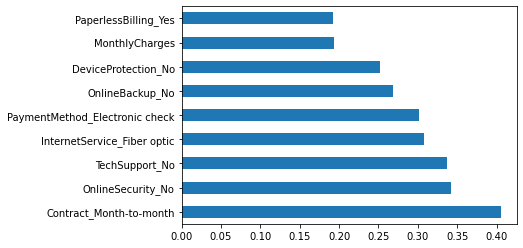

In [5]:
best_feat[1:10].plot(kind= 'barh')

We can see by the plot above, that some variables have might a positive relation to our target variable - Churn, while in plot below, some have negative relation. Positive relation meaning that the likeness of customer's churn increases by those vaiables, while in contrary, negative relation means that likeliness of churn decreases by that variable.

As mentioned in EDA, by having a one to two years contract along with tenure have the most negative relation with churn. Having DSL internet service also reduces the proability of churn. Lastly, total charges, monthly contracts, fiber optic internet services can lead to higher churn rates. This is interesting, although fiber optic services are actually faster, customers are likely to churn because of it.

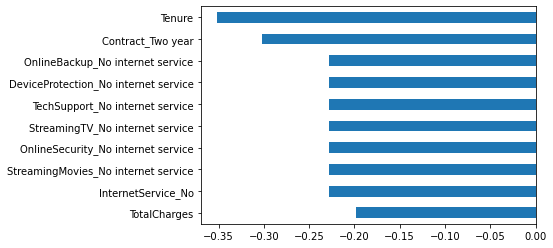

In [6]:
best_feat[-10:].plot(kind= 'barh')

In [7]:
df_new = df[['Churn', 'Contract_Month-to-month', 'OnlineSecurity_No', 'TechSupport_No', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 
             'OnlineBackup_No', 'DeviceProtection_No', 'PaperlessBilling_Yes', 'InternetService_No']]

In [8]:
df_new.head()

,Churn,Contract_Month-to-month,OnlineSecurity_No,TechSupport_No,InternetService_Fiber optic,PaymentMethod_Electronic check,OnlineBackup_No,DeviceProtection_No,PaperlessBilling_Yes,InternetService_No
0,0,1,1,1,0,1,0,1,1,0
1,0,0,0,1,0,0,1,0,0,0
2,1,1,0,1,0,0,0,1,1,0
3,0,0,0,0,0,0,1,0,0,0
4,1,1,1,1,1,1,1,1,1,0


### MODELLING

In [9]:
# splitting target 

x = df_new.drop(columns = ['Churn'])
y = df_new['Churn'].values

In [10]:
# Split train data 80%

x_train, x_test, y_train, y_test =  train_test_split(x, y, train_size = 0.8, shuffle = False)

# Model Best Parameter

LRG_best = LogisticRegression(solver = 'newton-cg', penalty = 'none', max_iter = 1000).fit(x_train, y_train)

In [11]:
# Predict using Logistic Regression

yp_LRG = LRG_best.predict(x_test)

In [12]:
labels = ['Not Churned', 'Churned']

              precision    recall  f1-score   support

 Not Churned       0.83      0.89      0.86      1028
     Churned       0.63      0.52      0.57       381

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



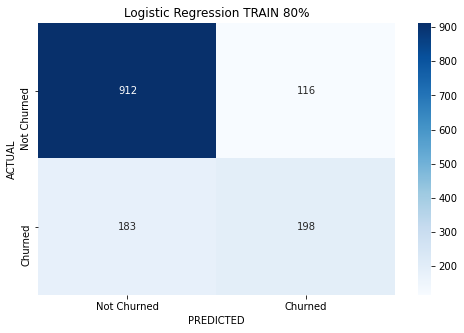

In [13]:
# Model evaluation

print(classification_report(y_test, yp_LRG, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, yp_LRG), annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Logistic Regression TRAIN 80%')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

It would seems that using these features / variables are causing a slight reduction on our recall of the churn customers. Therefore let's try to adding more variables, and see if the recall can be increased.

In [14]:
# adding Tenure, Monthly Charges, Contract Two Year and No Internet service

df_new1 = df[['Churn', 'Contract_Month-to-month', 'OnlineSecurity_No', 'TechSupport_No', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 
              'OnlineBackup_No', 'DeviceProtection_No', 'MonthlyCharges', 'PaperlessBilling_Yes', 'Tenure', 'Contract_Two year', 'InternetService_No']]

In [15]:
df_new1.head()

,Churn,Contract_Month-to-month,OnlineSecurity_No,TechSupport_No,InternetService_Fiber optic,PaymentMethod_Electronic check,OnlineBackup_No,DeviceProtection_No,MonthlyCharges,PaperlessBilling_Yes,Tenure,Contract_Two year,InternetService_No
0,0,1,1,1,0,1,0,1,0.115423,1,0.013889,0,0
1,0,0,0,1,0,0,1,0,0.385075,0,0.472222,0,0
2,1,1,0,1,0,0,0,1,0.354229,1,0.027778,0,0
3,0,0,0,0,0,0,1,0,0.239303,0,0.625000,0,0
4,1,1,1,1,1,1,1,1,0.521891,1,0.027778,0,0


In [16]:
# splitting target

x1 = df_new1.drop(columns = ['Churn'])
y1 = df_new1['Churn'].values

In [17]:
# Split train data 80%

x1_train, x1_test, y1_train, y1_test =  train_test_split(x1, y1, train_size = 0.8, shuffle = False)

# Model Best Parameter

LRG1_best = LogisticRegression(solver = 'newton-cg', penalty = 'none', max_iter = 1000).fit(x1_train, y1_train)

In [18]:
# Predict using Logistic Regression

yp_LRG1 = LRG1_best.predict(x1_test)

              precision    recall  f1-score   support

 Not Churned       0.83      0.91      0.87      1028
     Churned       0.67      0.50      0.57       381

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



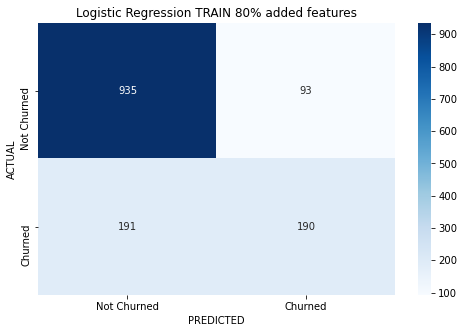

In [19]:
# Model evaluation

print(classification_report(y1_test, yp_LRG1, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y1_test, yp_LRG1), annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Logistic Regression TRAIN 80% added features')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

So it would seems that the recall would be decreased if we add more features / variables into it. Therefore we will choose the previous one.

### MODEL DEPLOYMENT

In [20]:
model = LRG_best

Let's try to predict the data using Logistic Regression Model that we've picked. I'll try to pick it randomly from our data.

In [21]:
df_new.loc[df_new['Churn']==0].tail()

,Churn,Contract_Month-to-month,OnlineSecurity_No,TechSupport_No,InternetService_Fiber optic,PaymentMethod_Electronic check,OnlineBackup_No,DeviceProtection_No,PaperlessBilling_Yes,InternetService_No
7037,0,0,0,0,0,0,0,0,1,1
7038,0,0,0,0,0,0,1,0,1,0
7039,0,0,1,1,1,0,0,0,1,0
7040,0,1,0,1,0,1,1,1,1,0
7042,0,0,0,0,1,0,1,0,1,0


In [22]:
# predicting not churn

data_noch1 = df_new.iloc[7037].drop('Churn').ravel().tolist()
data_noch2 = df_new.iloc[7040].drop('Churn').ravel().tolist()
data_noch3 = df_new.iloc[7042].drop('Churn').ravel().tolist()

In [23]:
print(data_noch1, data_noch2, data_noch3)

[0, 0, 0, 0, 0, 0, 0, 1, 1] [1, 0, 1, 0, 1, 1, 1, 1, 0] [0, 0, 0, 1, 0, 1, 0, 1, 0]


In [24]:
noch_test1 = model.predict_proba([data_noch1])[0][1]*100
noch_test2 = model.predict_proba([data_noch2])[0][1]*100
noch_test3 = model.predict_proba([data_noch3])[0][1]*100

In [25]:
noch_result1 = 'The probability of Churn is : {}%'.format(round(noch_test1),2)
noch_result2 = 'The probability of Churn is : {}%'.format(round(noch_test2),2)
noch_result3 = 'The probability of Churn is : {}%'.format(round(noch_test3),2)

In [26]:
print(noch_result1)
print(noch_result2)
print(noch_result3)

The probability of Churn is : 4.0%
The probability of Churn is : 39.0%
The probability of Churn is : 8.0%


We can see that out of three predictions, this model could correctly predict all of the Not Churned customers as the probability of Churn is still below 40%. Let's try to predict the Churned customers.

In [27]:
df_new.loc[df_new['Churn']==1].tail()

,Churn,Contract_Month-to-month,OnlineSecurity_No,TechSupport_No,InternetService_Fiber optic,PaymentMethod_Electronic check,OnlineBackup_No,DeviceProtection_No,PaperlessBilling_Yes,InternetService_No
7021,1,0,1,0,0,1,1,1,1,0
7026,1,1,1,1,0,0,1,1,1,0
7032,1,1,1,1,1,1,1,1,1,0
7034,1,1,0,1,1,0,0,0,1,0
7041,1,1,1,1,1,0,1,1,1,0


In [28]:
# predicting churn

data_ch1 = df_new.iloc[7021].drop('Churn').ravel().tolist()
data_ch2 = df_new.iloc[7032].drop('Churn').ravel().tolist()
data_ch3 = df_new.iloc[7041].drop('Churn').ravel().tolist()

In [29]:
print(data_ch1, data_ch2, data_ch3)

[0, 1, 0, 0, 1, 1, 1, 1, 0] [1, 1, 1, 1, 1, 1, 1, 1, 0] [1, 1, 1, 1, 0, 1, 1, 1, 0]


In [30]:
ch_test1 = model.predict_proba([data_ch1])[0][1]*100
ch_test2 = model.predict_proba([data_ch2])[0][1]*100
ch_test3 = model.predict_proba([data_ch3])[0][1]*100

In [31]:
ch_result1 = 'The probability of Churn is : {}%'.format(round(ch_test1),2)
ch_result2 = 'The probability of Churn is : {}%'.format(round(ch_test2),2)
ch_result3 = 'The probability of Churn is : {}%'.format(round(ch_test3),2)

In [32]:
print(ch_result1)
print(ch_result2)
print(ch_result3)

The probability of Churn is : 13.0%
The probability of Churn is : 70.0%
The probability of Churn is : 58.0%


As we can see, out of three predictions, this model only predicted right about two times. This would seems be caused by the somewhat low recall, I'll try to tweak it one more time to see if this problem still persist.

In [33]:
# Oversampling with SMOTE

x_train_sm, y_train_sm = SMOTE().fit_sample(x_train, y_train)

# Model Best Parameter oversampled

LRG_best_sm = LogisticRegression(solver = 'newton-cg', penalty = 'none', max_iter = 1000).fit(x_train_sm, y_train_sm)

In [34]:
# Predict using Logistic Regression oversampled

yp_LRG_sm = LRG_best_sm.predict(x_test)

              precision    recall  f1-score   support

 Not Churned       0.88      0.71      0.79      1028
     Churned       0.49      0.75      0.59       381

    accuracy                           0.72      1409
   macro avg       0.69      0.73      0.69      1409
weighted avg       0.78      0.72      0.74      1409



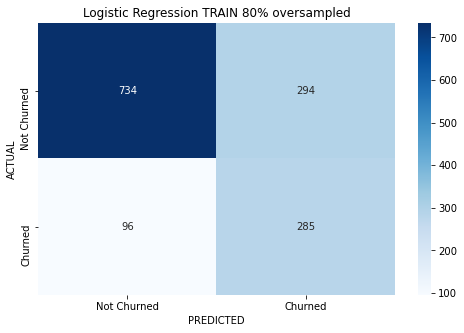

In [35]:
# Model evaluation

print(classification_report(y_test, yp_LRG_sm, target_names = labels))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, yp_LRG_sm), annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.title('Logistic Regression TRAIN 80% oversampled')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

Although it greatly lowers the accuracy and precision, personally I think the oversampled version is a better model for predicting especially in this business field. As of in this type of field the higher the recall the better, but of course we'll need to consider the other parameters, such as accuracy, precision, and f1 score. But for now let's continue to see if this is the better model than before.

In [36]:
model_sm = LRG_best_sm

In [37]:
# predicting not churn

noch_bal_test1 = model_sm.predict_proba([data_noch1])[0][1]*100
noch_bal_test2 = model_sm.predict_proba([data_noch2])[0][1]*100
noch_bal_test3 = model_sm.predict_proba([data_noch3])[0][1]*100

In [38]:
noch_result1_bal = 'The probability of Churn is : {}%'.format(round(noch_bal_test1),2)
noch_result2_bal = 'The probability of Churn is : {}%'.format(round(noch_bal_test2),2)
noch_result3_bal = 'The probability of Churn is : {}%'.format(round(noch_bal_test3),2)

In [39]:
print(noch_result1_bal)
print(noch_result2_bal)
print(noch_result3_bal)

The probability of Churn is : 10.0%
The probability of Churn is : 63.0%
The probability of Churn is : 20.0%


As we can see above, using a rather *'balanced'* data with oversampling technique would seems that it lowers the performance of this model instead. Out of three prediction, it only predicted right about two times, while using no balanced data as before was three out of three. But let's see how well this balanced models predict the churned customers.

In [40]:
# predicting churn

ch_bal_test1 = model_sm.predict_proba([data_ch1])[0][1]*100
ch_bal_test2 = model_sm.predict_proba([data_ch2])[0][1]*100
ch_bal_test3 = model_sm.predict_proba([data_ch3])[0][1]*100

In [41]:
ch_result1_bal = 'The probability of Churn is : {}%'.format(round(ch_bal_test1),2)
ch_result2_bal = 'The probability of Churn is : {}%'.format(round(ch_bal_test2),2)
ch_result3_bal = 'The probability of Churn is : {}%'.format(round(ch_bal_test3),2)

In [42]:
print(ch_result1_bal)
print(ch_result2_bal)
print(ch_result3_bal)

The probability of Churn is : 28.0%
The probability of Churn is : 86.0%
The probability of Churn is : 79.0%


It seems that this model also got one wrong in predicting the Churned customers. Therefore in conclusion we can say that the *'balanced'* version of this model would greatly lowers the model performances. Therefore I would choose the normal version instead. So below, I'll try to dump the model using joblib to apply it into Dashboard.

In [43]:
joblib.dump(model, 'LRG_model')

['LRG_model']